In [20]:
import cv2 

img = cv2.imread('test/asalto1.jpg')
print(img.shape[0], img.shape[1], img.shape[2], len(img.shape))

AttributeError: 'NoneType' object has no attribute 'shape'

# Convolutional Neural Networks

In [ ]:
pip install opencv-python


# Importar Librerías

In [21]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [22]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model, load_model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD


# Cargar set de Imágenes

In [115]:
dirname = os.path.join(os.getcwd(),'resul/')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            if(len(image.shape)==3):
                
                images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  c:\Users\LATITUDE\Desktop\IA_20120091\Entregables\CNN\resul/\
c:\Users\LATITUDE\Desktop\IA_20120091\Entregables\CNN\resul/\incendio 1
c:\Users\LATITUDE\Desktop\IA_20120091\Entregables\CNN\resul/\inundacion 14648
c:\Users\LATITUDE\Desktop\IA_20120091\Entregables\CNN\resul/\robo 9945
c:\Users\LATITUDE\Desktop\IA_20120091\Entregables\CNN\resul/\robocasa 9217
c:\Users\LATITUDE\Desktop\IA_20120091\Entregables\CNN\resul/\tornado 2244
Directorios leidos: 5
Imagenes en cada directorio [14649, 9945, 9217, 2244, 16493]
suma Total de imagenes en subdirs: 52548


# Creamos las etiquetas

In [116]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  52548


In [117]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 incendio
1 inundacion
2 robo
3 robocasa
4 tornado


In [118]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy



# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


# Creamos Sets de Entrenamiento y Test

In [119]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (42038, 30, 30, 3) (42038,)
Testing data shape :  (10510, 30, 30, 3) (10510,)


Text(0.5, 1.0, 'Ground Truth : 1')

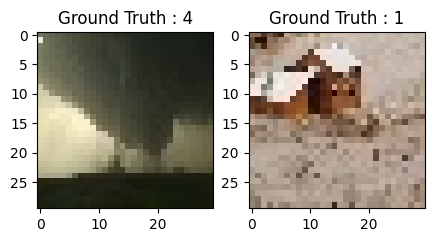

In [120]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

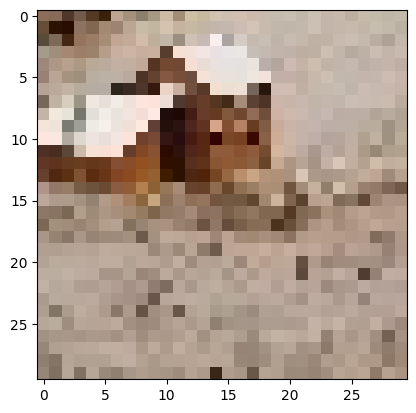

In [121]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [122]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 4
After conversion to one-hot: [0. 0. 0. 0. 1.]


# Creamos el Set de Entrenamiento y Validación

In [123]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [124]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(33630, 30, 30, 3) (8408, 30, 30, 3) (33630, 5) (8408, 5)


# Creamos el modelo de CNN

In [125]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 20 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [93]:
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(30,30,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))


sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

In [126]:
sport_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │       230,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,495 (904.28 KB)

 Trainable params: 231,493 (904.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [127]:
# sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

sport_model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),
    metrics=['accuracy']
)

C:\Users\LATITUDE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


# Entrenamos el modelo: Aprende a clasificar imágenes

In [97]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
# sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

sport_train = sport_model.fit(
    train_X, train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(valid_X, valid_label)
)

Epoch 1/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.2791 - loss: 1.5636 - val_accuracy: 0.7119 - val_loss: 1.3171
Epoch 2/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4905 - loss: 1.3456 - val_accuracy: 0.7634 - val_loss: 1.0750
Epoch 3/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.5810 - loss: 1.1578 - val_accuracy: 0.7889 - val_loss: 0.8835
Epoch 4/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.6462 - loss: 1.0018 - val_accuracy: 0.7931 - val_loss: 0.7533
Epoch 5/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.6877 - loss: 0.8988 - val_accuracy: 0.8044 - val_loss: 0.6697
Epoch 6/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.7185 - loss: 0.8205 - val_accuracy: 0.8405 - val_loss: 0.6022
Epoch 7/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.7417 - loss: 0.7586 - val_accuracy: 0.8710 - val_loss: 0.5524
Epoch 8/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.7618 - loss: 0.7136 - 

In [128]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("asd.h5")

# LOAD RED 

In [76]:
import tensorflow as tf

# Ruta del archivo .h5
model_path = 'red.h5'

# Cargar el modelo
sport_model = load_model(model_path)

# Verifica la estructura del modelo
sport_model.summary()

sport_model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),
    metrics=['accuracy']
)

sport_train = sport_model.fit(
    train_X, train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(valid_X, valid_label)
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       230,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,495 (904.28 KB)

 Trainable params: 231,493 (904.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Epoch 1/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9137 - loss: 0.2866 - val_accuracy: 0.9676 - val_loss: 0.1445
Epoch 2/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9189 - loss: 0.2715 - val_accuracy: 0.9678 - val_loss: 0.1372
Epoch 3/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9194 - loss: 0.2717 - val_accuracy: 0.9693 - val_loss: 0.1295
Epoch 4/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9223 - loss: 0.2618 - val_accuracy: 0.9703 - val_loss: 0.1249
Epoch 5/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9247 - loss: 0.2484 - val_accuracy: 0.9718 - val_loss: 0.1171
Epoch 6/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9307 - loss: 0.2377 - val_accuracy: 0.9731 - val_loss: 0.1119
Epoch 7/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9299 - loss: 0.2362 - val_accuracy: 0.9736 - val_loss: 0.1078
Epoch 8/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9343 - loss: 0.2202 - 

# Evaluamos la red

In [129]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9530 - loss: 0.1877


In [131]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.1897568553686142
Test accuracy: 0.953472912311554


In [132]:
sport_train.history

{'accuracy': [0.35774606466293335,
  0.5168896913528442,
  0.5948260426521301,
  0.6542372703552246,
  0.6945584416389465,
  0.7225691080093384,
  0.744335412979126,
  0.7702943682670593,
  0.7880463600158691,
  0.8037168979644775,
  0.8172464966773987,
  0.8274160027503967,
  0.8385964632034302,
  0.847754955291748,
  0.8578649759292603,
  0.8641688823699951,
  0.8746060132980347,
  0.877787709236145,
  0.8862325549125671,
  0.8906036019325256],
 'loss': [1.4941493272781372,
  1.2980693578720093,
  1.1197530031204224,
  0.98222416639328,
  0.884599506855011,
  0.8077398538589478,
  0.7516719698905945,
  0.6973533034324646,
  0.647095263004303,
  0.6068181991577148,
  0.5737507939338684,
  0.5373060703277588,
  0.504697322845459,
  0.47808483242988586,
  0.4522168040275574,
  0.42913174629211426,
  0.40456724166870117,
  0.38967493176460266,
  0.3693193197250366,
  0.3540938198566437],
 'val_accuracy': [0.7119410037994385,
  0.7634395956993103,
  0.7888915538787842,
  0.793054223060607

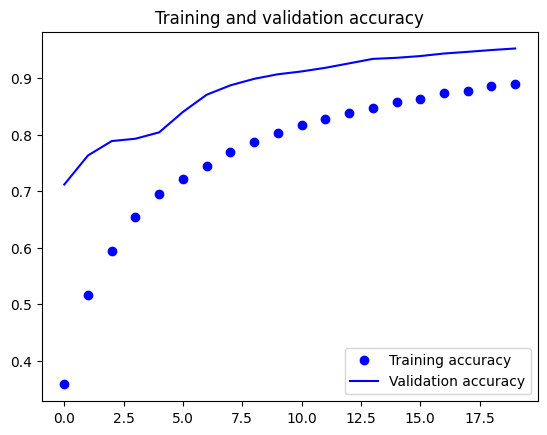

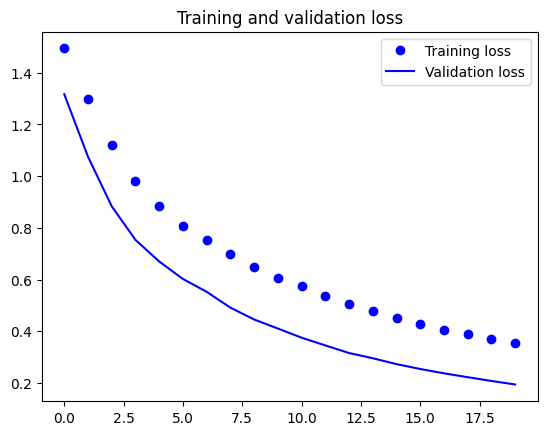

In [133]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [134]:
predicted_classes2 = sport_model.predict(test_X)

329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [135]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [136]:
predicted_classes.shape, test_Y.shape

((10510,), (10510,))

# Aprendamos de los errores: Qué mejorar

Found 10021 correct labels


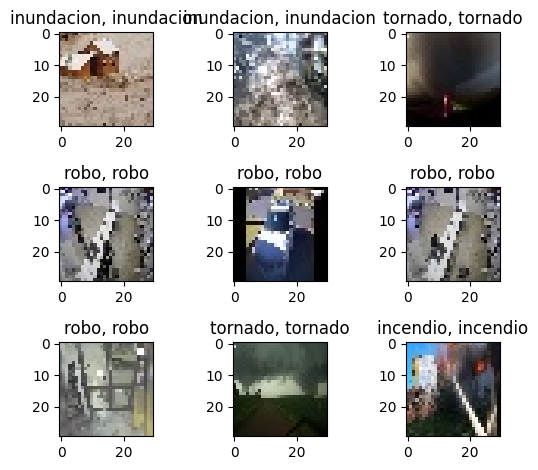

In [137]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(30,30,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 489 incorrect labels


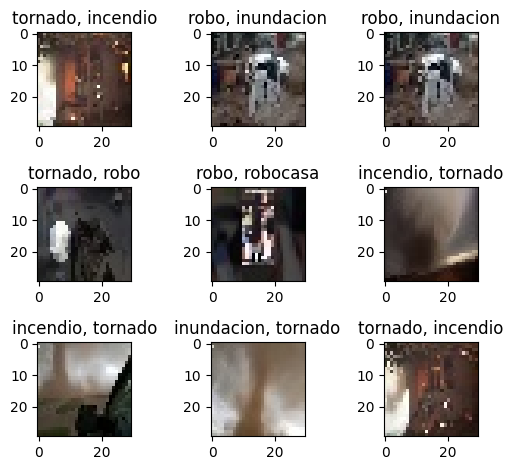

In [138]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(30,30,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [139]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.95      0.97      0.96      3056
     Class 1       0.92      0.90      0.91      1979
     Class 2       0.99      0.99      0.99      1797
     Class 3       1.00      0.88      0.94       460
     Class 4       0.96      0.96      0.96      3218

    accuracy                           0.95     10510
   macro avg       0.96      0.94      0.95     10510
weighted avg       0.95      0.95      0.95     10510



In [154]:
from skimage.transform import resize

images=[]
# AQUI ESPECIFICAMOS UNAS IMAGENES
filenames = ['test/inundacion8.jpg']

for filepath in filenames:
    image = plt.imread(filepath,0)
    image_resized = resize(image, (30, 30),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = sport_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], deportes[img_tagged.tolist().index(max(img_tagged))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
test/inundacion8.jpg inundacion
